In [ ]:
import numpy as np
import pandas as pd
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [ ]:
%matplotlib inline

## Looking at Data and Data Preparation
My first step is to always look at some basic descriptors of the dataset, make sure the data loaded correctly, and format the data as necessary. After determining how I want my dataset to be formatted, I will make those formats in an python file that I will load in each notebook. Rather than load the raw dataset, I will load my python file.

### Loading Data

In [ ]:
train_df = pd.read_csv('../data/kaggle_train.csv')

### Getting Basic Descriptors of Dataset
I always start by making sure the loaded data matches the data description and get a general idea of the dataset in the process

### Looking at Dimensions of Dataframe
The dataframe has 81 columns which matches the dataset description. According to the data description, the dataset includes 79 explanatory variables. This does not conflict with the loaded dataset because one column, Id does not contain an explanatory variable, and SalePrice is the target not an explantory variable.

For reference, the description can be found in the doc directory of this repository.

In [ ]:
train_df.shape
dimm = train_df.shape; print(dimm)
n_obs = dimm[0]

In [ ]:
train_df.head(3)

In [ ]:
train_df.info()

### Using Id Column to Index ames_df
It is good practice to index the dataframe. We will use the Id column to index the data frame and then drop that. It is unique and has no predictive value. First, we will check if the Id column is unique.

In [ ]:
train_df[train_df.Id.duplicated()]

In [ ]:
train_df =  train_df.set_index('Id')

In [ ]:
######### train.3SsnPorch not valid #########
train_df = train_df.rename(columns={ '3SsnPorch': 'ThreeSsnPorch'})

## Imputing Nan Values That Add Information
Nan values are difficult to work with programmatically.The data description lists the following features as having nan value that add information unlike nans that mean a data point is unknown or missing. Those features describe physical structures that may not exist in a home. For example, a nan value in PoolQC means there is no pool. It stands to reason that if PoolQC is nan, then PoolArea should be nan or zero. Let's (1) spot check that those features do not contradict each other and (2) replace nan values in columns strings such as 'none' or the number zero. 


- Alley
- MasVnrType
- MasVnrArea
- BsmtQual 
- BsmtCond 
- BsmtExposure
- BsmtFinType1
- BsmtFinSF1 
- BsmtFinType2
- BsmtFinSF2
- BsmtUnfSF
- TotalBsmtSF
- BsmtFullBath
- BsmtHalfBath
- FireplaceQu  
- GarageType  
- GarageYrBlt  
- GarageFinish  
- GarageCars
- GarageArea 
- GarageQual 
- GarageCond 
- PoolQC 
- Fence 
- MiscFeature

In [ ]:
dimm = train_df.shape
n_obs = dimm[0]
n_non_nans = train_df.count()
n_nans = n_obs - n_non_nans
feat_w_nan = n_nans[n_nans > 0]
print(feat_w_nan.sort_values(ascending=False))

In [ ]:
def check_nans(name_of_feats):
    df = train_df[name_of_feats].copy()
    for n in name_of_feats:
        print(df[n].unique())
    if len(name_of_feats) > 2:
        for name in name_of_feats:
            mask = df.isnull().any(axis = 1)
            rows_w_nans_unique = df[mask].drop_duplicates()
        display('unique combination of column values for columns with nans')
        display(rows_w_nans_unique)
            
    elif len(name_of_feats) == 2:
        for n in name_of_feats:
            feat_is_numeric = (df[n].dtype == np.float64) or (df[n].dtype == np.int64)
            if feat_is_numeric:
                is_0 = df[n] == 0
                is__null = df[n].isnull() == False
                is_more_than_0 = df[n] > 0
                
                df[n] = df[n].fillna('nan')
                df[n][is_0] = 'zero'
                df[n][is_more_than_0] = 'not_0'
    
            else:
                df[n] = df[n].fillna('nan')
                
        display(pd.crosstab(index = df[name_of_feats[0]], 
                            columns = df[name_of_feats[1]]))
        
        display(pd.crosstab(index = df[name_of_feats[0]], 
                                columns = df[name_of_feats[1]], normalize = 'index'))
        

#### Pool
##### From Data Description:
>Pool Area (Continuous): Pool area in square feet
>
>Pool QC (Ordinal): Pool quality
>		
>       Ex	Excellent
>       Gd	Good
>       TA	Average/Typical
>       Fa	Fair
>       NA	No Pool

First, we are looking all the possible values that the attribute takes on. Perhaps one column includes nans and a value implying there is no pool. This would mean that the nans do not mean there is no pool but, rather, we do not know if there is a pool or there is a pool and we do not know the pool quality.

Second, we look at contingency tables to make sure that there are no rows where one attribute implies there is a pool and another implies the opposite. We can see that all 1453 rows where `PoolQC` = nan also have `PoolArea` = 0 and vice-versa. There is no discrepency.

In [ ]:
pool_feats = ['PoolArea', 'PoolQC']
check_nans(pool_feats)

train_df.PoolQC = train_df.PoolQC.fillna('none')

#### Features Describing Fireplaces

##### From Data Description
>Fireplaces (Discrete): Number of fireplaces
>
>FireplaceQu (Ordinal): Fireplace quality
>
>       Ex	Excellent - Exceptional Masonry Fireplace
>       Gd	Good - Masonry Fireplace in main level
>       TA	Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement
>       Fa	Fair - Prefabricated Fireplace in basement
>       Po	Poor - Ben Franklin Stove
>       NA	No Fireplace


In [ ]:
check_nans(['Fireplaces', 'FireplaceQu'])

train_df.FireplaceQu = train_df.FireplaceQu.fillna('none')

In [ ]:
garage_feats = ['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond']
check_nans(garage_feats)

train_df.GarageType  = train_df.GarageType.fillna('none')
train_df.GarageYrBlt = train_df.GarageYrBlt.fillna('none')
train_df.GarageFinish = train_df.GarageFinish.fillna('none')
train_df.GarageQual = train_df.GarageQual.fillna('none')
train_df.GarageCond = train_df.GarageCond.fillna('none')

### Basment
BsmtQual: Evaluates the height of the basement

       Ex	Excellent (100+ inches)	
       Gd	Good (90-99 inches)
       TA	Typical (80-89 inches)
       Fa	Fair (70-79 inches)
       Po	Poor (<70 inches
       NA	No Basement
		
BsmtCond: Evaluates the general condition of the basement

       Ex	Excellent
       Gd	Good
       TA	Typical - slight dampness allowed
       Fa	Fair - dampness or some cracking or settling
       Po	Poor - Severe cracking, settling, or wetness
       NA	No Basement
	
BsmtExposure: Refers to walkout or garden level walls

       Gd	Good Exposure
       Av	Average Exposure (split levels or foyers typically score average or above)	
       Mn	Mimimum Exposure
       No	No Exposure
       NA	No Basement
	
BsmtFinType1: Rating of basement finished area

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement
		
BsmtFinSF1: Type 1 finished square feet

BsmtFinType2: Rating of basement finished area (if multiple types)

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement

BsmtFinSF2: Type 2 finished square feet

BsmtUnfSF: Unfinished square feet of basement area

TotalBsmtSF: Total square feet of basement area

In [ ]:
basement_feats = ['BsmtFullBath', 'BsmtHalfBath',
                  'BsmtQual', 'BsmtCond',
                  'BsmtFinType1', 'BsmtFinType2', 'BsmtExposure']
check_nans(basement_feats)

train_df.BsmtQual = train_df.BsmtQual.fillna('none')
train_df.BsmtCond = train_df.BsmtCond.fillna('none')
train_df.BsmtFinType1 = train_df.BsmtFinType1.fillna('none')
train_df.BsmtFinType2 = train_df.BsmtFinType2.fillna('none')
train_df.BsmtExposure = train_df.BsmtExposure.fillna('none')

#### Fence
>Fence (Ordinal): Fence quality
>		
>       GdPrv	Good Privacy
>       MnPrv	Minimum Privacy
>       GdWo	Good Wood
>       MnWw	Minimum Wood/Wire
>       NA	No Fence

In [ ]:
check_nans(['Fence'])

train_df.Fence = train_df.Fence.fillna('none')

### `MiscFeature`
From data description:
>MiscFeature: Miscellaneous feature not covered in other categories
>		
>       Elev	Elevator
>       Gar2	2nd Garage (if not described in garage section)
>       Othr	Other
>       Shed	Shed (over 100 SF)
>       TenC	Tennis Court
>       NA	None
>MiscVal: $Value of miscellaneous feature

In [ ]:
check_nans(['MiscFeature', 'MiscVal'])

train_df.MiscFeature = train_df.MiscFeature.fillna('none')

### `Alley`
>Alley: Type of alley access to property
>
>       Grvl	Gravel
>       Pave	Paved
>       NA 	No alley access

In [ ]:
check_nans(['Alley'])

train_df.Alley = train_df.Alley.fillna('none')

### Nan in Electrical Column
There is only one nan in this column. This is an anomoly. We will just drop this observation. The dataset contains 1460 observations, so dropping one is trivial. 

Electrical (Ordinal): Electrical system

       SBrkr	Standard Circuit Breakers & Romex
       FuseA	Fuse Box over 60 AMP and all Romex wiring (Average)	
       FuseF	60 AMP Fuse Box and mostly Romex wiring (Fair)
       FuseP	60 AMP Fuse Box and mostly knob & tube wiring (poor)
       Mix	Mixed

In [ ]:
n_non_nan_Electrical = train_df['Electrical'].count()
# dataframe.count() returns the nbr of non-NA values
# df.count() is a Pandas data structure series. It is one-dimensional 
# labeled array capable of holding any data type.

n_nan_Electrical = n_obs - n_non_nan_Electrical

one_obs_with_nan_Electrical = train_df.Electrical.isnull()
train_df = train_df[one_obs_with_nan_Electrical == False]

train_df.shape

### Nans in `LotFrontage`
From data description:
>Lot Frontage (Continuous): Linear feet of street connected to property

In real estate, frontage is the width of a lot, measured at the front part of the lot. Every house has lot frontage. That means nans in that column means missing data. 

#### Dealing with Missing Data
At first glance, you would think you can just ignore the missing data and do your normal calculations. We have lot frontage for 1200 of the 1460 observations in the dataset. We can just make do with the average of the 1200 values that we do know. However, just acting as if those unknown values do not exist actually affect our calculations more than not. 

There is no one best way to handle missing data that works in all cases. Generally, one of our goals is to make our missing data be as innocuous as possible. Let's act as if those nan values equal the mean of the known data. 

In [ ]:
train_df.LotFrontage.count()

In [ ]:
def hist_feat(feature):
    meann = feature.dropna().mean(); mediann = feature.dropna().median()
    minn = feature.min(); x_lim = meann + 4*feature.dropna().std()

    sns.distplot(feature.dropna(), kde=False, hist_kws = {'range': [minn, x_lim]})
    plt.axvline(meann, label = 'mean')
    plt.axvline(mediann, color = 'r', label = 'median')
    plt.legend()
    
def hist_before_nan_to_mean(feature):
    fig = plt.figure(); fig.add_subplot(1,2,1)
    hist_feat(feature)
    
    dummy = feature.copy()
    mask = dummy.isnull()
    meann = dummy.dropna().mean()
    dummy[mask] = meann
    
    fig.add_subplot(1,2,2)
    hist_feat(dummy)

hist_before_nan_to_mean(train_df.LotFrontage)

meann = train_df.LotFrontage.mean()
train_df.LotFrontage = train_df.LotFrontage.fillna(meann)

### `MasVnrType` and `MasVnrArea`
>MasVnrType: Masonry veneer type
>
>       BrkCmn	Brick Common
>       BrkFace	Brick Face
>       CBlock	Cinder Block
>       None	None
>       Stone	Stone
>	
>MasVnrArea: Masonry veneer area in square feet

There are two houses described as having some type of masonry veneer and masonry veneer areas of zero. That seems to be an error. Because there are only two observations with that error, we will just drop those two rows. 

In [ ]:
masonry_veneer = ['MasVnrType', 'MasVnrArea']
check_nans(masonry_veneer)

In [ ]:
pd.crosstab(index = train_df['MasVnrType'], columns = train_df['MasVnrArea'])

In [ ]:
area_0_to_drop = train_df[train_df.MasVnrArea == 0]
stone_to_drop = area_0_to_drop[train_df.MasVnrType == 'Stone'].index.values
brickface_to_drop = area_0_to_drop[train_df.MasVnrType == 'BrkFace'].index.values

train_df = train_df.drop(stone_to_drop)
train_df = train_df.drop(brickface_to_drop)

no_mv = train_df[train_df.MasVnrType == 'None']
area_not_zero_to_drop = no_mv[no_mv.MasVnrArea > 0].index.values
train_df = train_df.drop(area_not_zero_to_drop)

train_df.MasVnrArea = train_df.MasVnrArea.fillna(0)
train_df.MasVnrType = train_df.MasVnrType.fillna('None')

In [ ]:
def display_outliers(dataframe, col, param=1.5):
    Q1 = np.percentile(dataframe[col], 25)
    Q3 = np.percentile(dataframe[col], 75)
    tukey_window = param*(Q3-Q1)
    less_than_Q1 = dataframe[col] < Q1 - tukey_window
    greater_than_Q3 = dataframe[col] > Q3 + tukey_window
    tukey_mask = (less_than_Q1 | greater_than_Q3)
    return dataframe[tukey_mask]

numerical_features = set()
for col in train_df:
    data_type = train_df[col].dtype
    col_is_num = (data_type == np.dtype('float')) or (data_type == np.dtype('int'))
    if col_is_num:
        numerical_features.add(col)

num_df = train_df[list(numerical_features)]

for col in numerical_features:
    print(col, 
          display_outliers(train_df, col).shape[0])

What if we count the rows that show up as an outlier more than once?

In [ ]:
raw_outliers = []
for col in numerical_features:
    outlier_df = display_outliers(train_df, col, param = 1.5)
    raw_outliers += list(outlier_df.index)
    

outlier_count = Counter(raw_outliers)
outlier_count.items()

How many outliers are outliers for more than one feature?

In [ ]:
table_ = Counter(outlier_count.values())
dict(table_)

n_feats = list(outlier_count.values())
sns.countplot(n_feats)
plt.title('Count of Outliers and For How Many Features')
plt.ylabel('number of outliers')
plt.xlabel('number of features')

fig = plt.figure(figsize=(12,10))
fig.add_subplot(2,1,1)
for i in range(1,3):
    outliers = [k for k,v in outlier_count.items() if v > i]
    distplot_needs_more_vals = len(outliers) < 2
    if distplot_needs_more_vals:
        pass
    else:
        sns.distplot(train_df.SalePrice.loc[outliers],
                     label = 'outliers for ' + str(i) + ' features')

sns.distplot(train_df.SalePrice,
             label = 'all houses')
plt.legend()        

fig.add_subplot(2,1,2)
for i in range(3,11):
    outliers = [k for k,v in outlier_count.items() if v > i]
    
    distplot_needs_more_vals = len(outliers) < 2
    if distplot_needs_more_vals:
        pass
    else:
        sns.distplot(train_df.SalePrice.loc[outliers],
                     label = 'outliers for ' + str(i) + ' features')

sns.distplot(train_df.SalePrice,
             label = 'all houses')
plt.legend()        



extreme_outliers = [k for k,v in outlier_count.items() if v > 5]

train_df.loc[extreme_outliers]

extreme_outliers

# def get_percentile(ndx, column):
#     df = num_df[column]
#     df['pct'] = df.rank(pct = True)
#     percentile = df[df[column] == value]
    
    
def is_outlier_for_which_feats(ndx, param = 1.5):
    for_which_feats = []
    for col in num_df:
        col_df = num_df[col]
        Q1 = np.percentile(col_df, 25)
        Q3 = np.percentile(col_df, 75)
        tukey_window = param*(Q3-Q1)
        
        num = col_df.loc[ndx]
        less_than_Q1 = num < Q1 - tukey_window
        greater_than_Q3 = num > Q3 + tukey_window
        
        if less_than_Q1 or greater_than_Q3:
            percentile = col_df.rank(pct = True).loc[ndx]
            for_which_feats.append((col, percentile))
    return for_which_feats

for outlier in extreme_outliers:
    print(outlier)
    print('SalePrice', 
          num_df.SalePrice.rank(pct=True).loc[outlier])
    for f in is_outlier_for_which_feats(outlier):
        print(f)
    print()

price_outliers = display_outliers(train_df, 'SalePrice')
sns.distplot(price_outliers.SalePrice)

outliers

In [ ]:
cond1_df = pd.get_dummies(train_df['Condition1'], prefix='cond')
cond2_df = pd.get_dummies(train_df['Condition2'], prefix = 'cond')
cond2_df['RRNe'] = 0
cond_df = cond1_df
cond_df[cond2_df == 1] = cond_df + 1
cond_df[cond_df == 2] = 1
conds = ['Condition1', 'Condition2']
train_df = train_df.drop(conds, axis = 'columns')
cbind = 1
train_df = pd.concat([train_df, cond_df], axis = cbind)

bm1_df = pd.get_dummies(train_df['BsmtFinType1'], prefix = 'BsmtFinType')
bm2_df = pd.get_dummies(train_df['BsmtFinType2'], prefix = 'BsmtFinType')
bm_df = bm1_df
bm_df[bm2_df == 1] = bm_df + 1
bm_df[bm_df == 2] = 1
bm = ['BsmtFinType1', 'BsmtFinType2']
train_df = train_df.drop(bm, axis = 'columns')
train_df = pd.concat([train_df, bm_df], axis = cbind)

ext1_df = pd.get_dummies(train_df['Exterior1st'], prefix = 'Exterior')
ext2_df = pd.get_dummies(train_df['Exterior2nd'], prefix = 'Exterior')
ext_df = ext1_df
ext_df[ext2_df == 1] = ext_df + 1
ext_df[ext_df == 2] = 1
ext = ['Exterior1st', 'Exterior2nd']
train_df = train_df.drop(ext, axis = 'columns')
cbind = 1
train_df = pd.concat([train_df, ext_df], axis = cbind)

In [ ]:
yr_feat = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']
for y in yr_feat:
    no_bin_nones = train_df[y].isin(['none']) == False
    yrs = train_df[y][no_bin_nones].unique()
    print(y, yrs.min(), yrs.max())

bins = list(range(1800, 2011, 10))
pd.options.display.max_rows = 10
train_df.YearBuilt = pd.cut(train_df.YearBuilt, bins)
train_df.YearRemodAdd = pd.cut(train_df.YearRemodAdd, bins)

no_bin_nones = train_df[y].isin(['none']) == False
train_df.GarageYrBlt[no_bin_nones] = pd.cut(train_df.GarageYrBlt[no_bin_nones], bins)

In [ ]:
### ONE-HOT ENCODE CATEGORICAL FEATURES ###
cat_feats = ['MSSubClass', 'MSZoning', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 
       'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars','GarageQual', 'GarageCond',
       'PavedDrive','ThreeSsnPorch',
       'ScreenPorch', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal',
       'MoSold', 'YrSold', 'SaleType', 'SaleCondition']

In [ ]:
for c in cat_feats:
    length = train_df[c].unique().size
    print(c, length)

In [ ]:
train_df[cat_feats].head()
made_binary = pd.get_dummies(data = train_df, prefix = cat_feats, columns = cat_feats)

In [ ]:
################### SCALING USING SCIKIT LEARN ##################
# >>> from sklearn.preprocessing import StandardScaler
# >>>
# >>> data = [[0, 0], [0, 0], [1, 1], [1, 1]]
# >>> scaler = StandardScaler()
# >>> print(scaler.fit(data))
# StandardScaler(copy=True, with_mean=True, with_std=True)
# >>> print(scaler.mean_)
# [ 0.5  0.5]
# >>> print(scaler.transform(data))
# [[-1. -1.]
#  [-1. -1.]
#  [ 1.  1.]
#  [ 1.  1.]]
# >>> print(scaler.transform([[2, 2]]))
# [[ 3.  3.]]

In [ ]:
made_binary.shape

In [ ]:
non_binary = train_df.drop(columns = cat_feats).columns.values

In [ ]:
made_binary[non_binary].shape

In [ ]:
pd.options.display.max_rows = 999

In [ ]:
made_binary.drop(columns = non_binary).head().transpose()

In [ ]:
from sklearn.linear_model import Ridge
from sklearn import linear_model

`sklearn.preprocessing.StandardScaler(X, y = none)`  
X : numpy array of shape [n_samples, n_features]; Training set.  
y : numpy array of shape [n_samples]; Target values.  

Returns:	X_new : numpy array of shape [n_samples, n_features_new]  

In [83]:
## feature selection using Lasso
X = made_binary.drop(columns = 'SalePrice')
y = train_df.SalePrice

import sklearn.preprocessing as preprocessing
X_scaled = preprocessing.scale(X.values)
X = pd.DataFrame(X_scaled, index = X.index, columns = X.columns)
y_scaled = preprocessing.scale(y.values)
y = pd.Series(y_scaled, index = y.index, name = y.name)

,0,1
0,GrLivArea,0.332908
1,TotalBsmtSF,0.112202
2,GarageCars_3,0.097470
3,BsmtQual_Ex,0.091741
4,GarageArea,0.081479
5,KitchenQual_Ex,0.060960
6,BsmtFinType_GLQ,0.043763
7,BsmtExposure_Gd,0.023332
8,OverallQual_9,0.021100
9,BsmtFinSF1,0.020164


,0,1
510,FireplaceQu_none,-2.544643e-16
511,GarageFinish_Unf,-7.459052e-05
512,"YearRemodAdd_(1940, 1950]",-2.939146e-03
513,MSZoning_RM,-7.460638e-03
514,CentralAir_N,-8.461471e-03
515,BsmtQual_TA,-1.742516e-02
516,KitchenQual_TA,-3.544409e-02
517,Fireplaces_0,-4.141052e-02
518,RoofMatl_ClyTile,-5.151041e-02
519,ExterQual_TA,-9.077662e-02


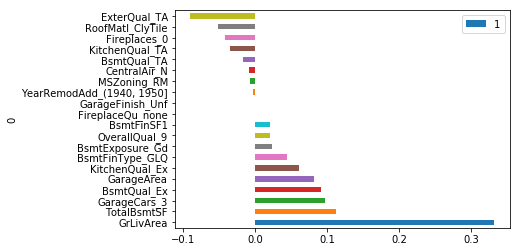

In [86]:
def plot_coef(model, top_n = 10):
    '''
    Plots the magnitude of coefficients
    '''
    cols = X.columns
    coef = model.coef_
    zipped = list(zip(cols, coef))
    zipped.sort(key=lambda x: x[1], reverse = True)
    top_10 = pd.DataFrame(zipped).head(top_n)
    bottom_10 = pd.DataFrame(zipped).tail(top_n)
    display(top_10)
    display(bottom_10)
    return pd.concat([top_10, bottom_10], axis=0).plot.barh(x = 0, y = 1)

lasso = linear_model.Lasso(alpha=0.1)
lasso.fit(X, y)
# print(lasso.coef_)
# print(lasso.intercept_)

# lasso.score(X,y)

# lasso.coef_

plot_coef(lasso)

### Interpretation of Ridge and Lasso Results
Ridge and lasso is just ordinary least squares (OLS) linear regression subject to constraints to reduce the variance of the our coefficient estimators. Unlike OLS, it is not unbiased (according to Gauss-Markov Theorem) but when our features are highly correlated, our coefficient estimators have high variance. 

From the $R^{2}$, which is the proportion of the explained variance to the total variance, we see that our dataset is very linear and linear regression is appropriate. Because it is linear, using ANOVA for feature selection/elimination was appropriate. 

Lasso can be preferable to Ridge regression because Lasso usually helps with feature selection. Lasso regression subjects our linear model to the constraint that the L1-norm of our coefficent estimator vector be less than some constant, unlike Ridge regression which uses the L2-norm. The L1-norm is pointy and the optimized linear regression subject to the L1-penalty usually "hits" an edge where coefficient estimators are zero or very small. 
Lasso was not necessary for feature selection in this case as we can see the ridge regression model is nearly identical to the lasso regression model. 

We can see from our coefficent estimators which feature is most useful for predicting sale. price. The larger the coeffient, the larger the "effect" (remember that association does not imply causation).

Note: informal derivation of Ridge and Lasso in doc directory

#### Ridge

In [ ]:
X = train_df.drop(columns = ['SalePrice'])
y = train_df.SalePrice
ridge = Ridge(alpha=1.0)
ridge.fit(train_df.drop(columns = ['SalePrice']), train_df.SalePrice) 

ridge_r2 = ridge.score(X,y); print(ridge_r2)

ridge.coef_

X.columns



plot_coef(ridge)

#### Lasso

In [ ]:
lasso = linear_model.Lasso(alpha=0.1)
lasso.fit(X, y)
print(lasso.coef_)
print(lasso.intercept_)

lasso.score(X,y)

lasso.coef_

plot_coef(ridge)

Ordinal Categorical Features
The following features are ordinal, but that does not necessarily mean they should be numerical. There are two reasons why I am making the following ordinal features categorical.

We cannot say with certainty that the difference between two consecutive values of these ordinal features is not the same as the difference between between two other consecutive values. Take OverallQual for example. It would be reasonable to say that the difference between a house with "OverallQual 4 Below Average" (data description) and a house with "OverallQual 5 Average" is not the same as the difference between a house with OverallQual being very excellent and a house with OverallQual being excellent. We would say there is diminishing returns.

We could scale the values to reflect the true relationship, but that will likely introduce a lot of error. It is better to not use the ordinality of these features than to use it incorrectly.

In [ ]:
########### SCATTER PLOTS ###############
fig = plt.figure(figsize=(15,50))
for i, col in enumerate(numeric_cols[:-1]):
    fig.add_subplot(12,3,1+i)
    plt.scatter(house_df[col], house_df['SalePrice'])
    plt.xlabel(col)
    plt.ylabel('SalePrice')
fig.tight_layout()
plt.show